In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import pandas as pd 
import warnings
import os
import cv2
from PIL import Image,ImageOps
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import random as rnd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

%matplotlib inline

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1/(1+np.exp(-z))
    
    return s

In [ ]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [ ]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X) + b)              # compute activation
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m  # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m

    #print(((A-Y).T).shape)
    #print(cost)
    #print(db)
    #print(dw.shape)
    #print(w.shape)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation
        
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

        params = {"w": w, "b": b}
    
        grads = {"dw": dw, "db": db}
    
    return params, grads, costs

In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    
    A = sigmoid(np.dot(w.T,X) + b) 
    
    for i in range(A.shape[1]):
        #Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i] >= 0.5):
             Y_prediction[0, i] = 1
        else:
             Y_prediction[0, i] = 0
    
    
    #VECTORISED IMPLEMENTATION ####
    #Y_prediction = (A >= 0.5) * 1.0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 200, learning_rate = 0.005, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

## Loading Data

In [ ]:
import zipfile
with zipfile.ZipFile("archive (1).zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
img_size = 75
batch_size= 32

train_datagen = ImageDataGenerator(rescale=1/255., validation_split = 0.05)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('PandasBears/Train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    subset = 'training',
                                                    class_mode ='binary')

val_generator = train_datagen.flow_from_directory('PandasBears/Train',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                subset = 'validation',
                                                class_mode ='binary')

test_generator = test_datagen.flow_from_directory('PandasBears/Test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                shuffle = False,
                                                class_mode ='binary')

Found 476 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
train_set_x = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
train_set_y = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
test_set_x = np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
test_set_y = np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
classes = ['bear', 'panda']

In [ ]:
train_set_x = train_set_x.reshape(train_set_x.shape[1]*train_set_x.shape[2]*train_set_x.shape[3], train_set_x.shape[0])
train_set_y = train_set_y.reshape(1, train_set_y.shape[0])
test_set_x = test_set_x.reshape(test_set_x.shape[1]*test_set_x.shape[2]*test_set_x.shape[3], test_set_x.shape[0])
test_set_y = test_set_y.reshape(1, test_set_y.shape[0])

In [ ]:
train_set_x.shape

(16875, 476)

In [ ]:
train_set_y.shape

(1, 476)

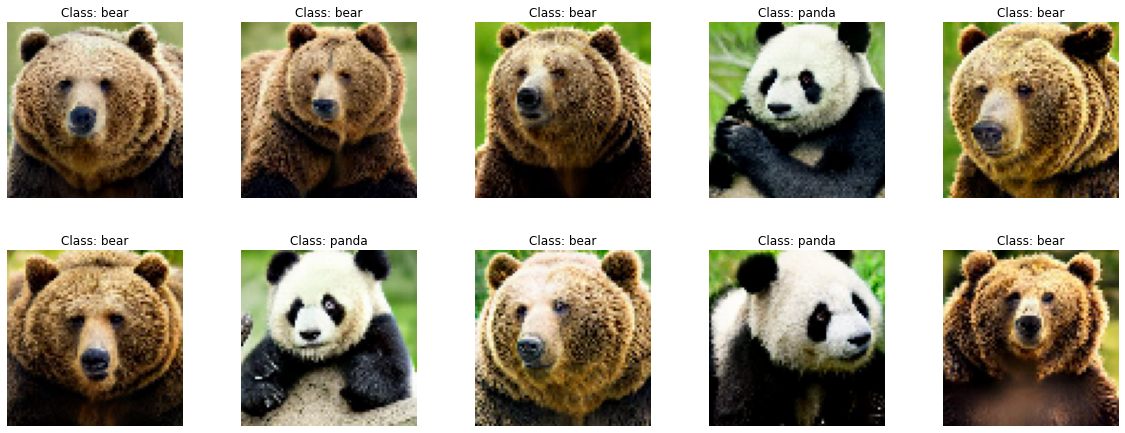

In [ ]:
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {classes[int(target[i])]}")
    plt.axis('off')

## Training Model

In [ ]:
model_dict = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.0025, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.650998
Cost after iteration 200: 0.627934
Cost after iteration 300: 0.609485
Cost after iteration 400: 0.593757
Cost after iteration 500: 0.579804
Cost after iteration 600: 0.567166
Cost after iteration 700: 0.555564
Cost after iteration 800: 0.544810
Cost after iteration 900: 0.534769
Cost after iteration 1000: 0.525341
Cost after iteration 1100: 0.516447
Cost after iteration 1200: 0.508024
Cost after iteration 1300: 0.500022
Cost after iteration 1400: 0.492397
Cost after iteration 1500: 0.485115
Cost after iteration 1600: 0.478145
Cost after iteration 1700: 0.471459
Cost after iteration 1800: 0.465036
Cost after iteration 1900: 0.458854
train accuracy: 83.19327731092437 %
test accuracy: 51.0 %
